### 6.6 Model CatBoost (handle missing value and categorical variables)

In [84]:
# load basic libraries
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [85]:
# import os
# import warnings
# warnings.filterwarnings("ignore")

# import pandas as pd
# # import datetime
# import seaborn as sns
# sns.set()
# import matplotlib.pyplot as plt
# import numpy as np
# # from scipy import stats
# # import random
# import category_encoders as ce
# from category_encoders import LeaveOneOutEncoder, TargetEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split 
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn import model_selection

# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier
# import lightgbm as lgb

# import time
# from sklearn.metrics import recall_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import f1_score
# from sklearn import metrics
# from sklearn.metrics import f1_score
# from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
# from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# from imblearn.over_sampling import SMOTE

# from tabulate import tabulate
# %matplotlib inline

In [86]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone
/Users/liuyang/Desktop/Springboard_Capstone


In [87]:
df = pd.read_csv('data/train.csv')

In [88]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [89]:
df.shape

(18359, 14)

In [90]:
X = df.drop(['target','enrollee_id'],axis=1)
y = df['target']

In [91]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [92]:
for i in cat_features:
    X[i].fillna('None', inplace =True)

In [93]:
# X[cat_features].isnull().sum()

In [94]:
cat_features_indices = []
cat_features
for i, j in enumerate(X.columns):
    if j in cat_features:
        cat_features_indices.append(i)

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.ravel(), test_size=0.30, stratify=y, random_state=43)

In [97]:
y_test.sum()

728

In [98]:
from sklearn.model_selection import KFold


In [99]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold, cat_features = cat_features_indices, silent=True)
    
    return model

In [100]:
from catboost import CatBoostClassifier
import scikitplot as skplt 
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score

In [101]:
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2, xlim):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    Target_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    Target_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.set_xlim([0, xlim])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, Target_in_top20pct, Target_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'Target_in_top20pct', 'Target_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.808,0.012,0.024,0.73,795.0,1297.0


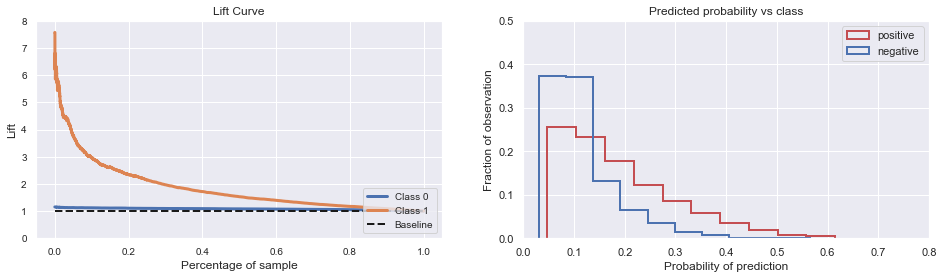

In [102]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_train, y_train, 8, 0.5, 0.8)

,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.5,0.005,0.011,0.662,275.0,514.0


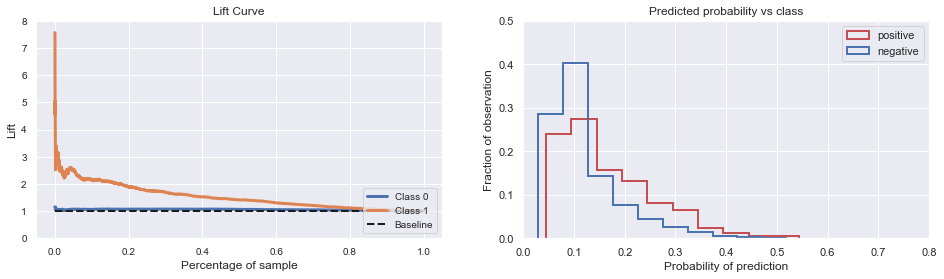

In [103]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_test, y_test, 8, 0.5, 0.8)

# 7 Hyper Parameter Tuning

In [77]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(1, 5),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(800, 1100)
                 }
    
randm = RandomizedSearchCV(estimator=CatBoostClassifier(silent=True), param_distributions = parameters, 
                           cv = 3)
randm.fit(X_train, y_train,cat_features= cat_features_indices)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)


 Results from Random Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8677923759848194

 The best parameters across ALL searched params:
 {'depth': 2, 'iterations': 988, 'learning_rate': 0.07165655594038356}


,precison,recall,f1score,roc_auc,Target_in_top20pct,Target_in_top50pct
CatB,0.571,0.005,0.011,0.664,283.0,515.0


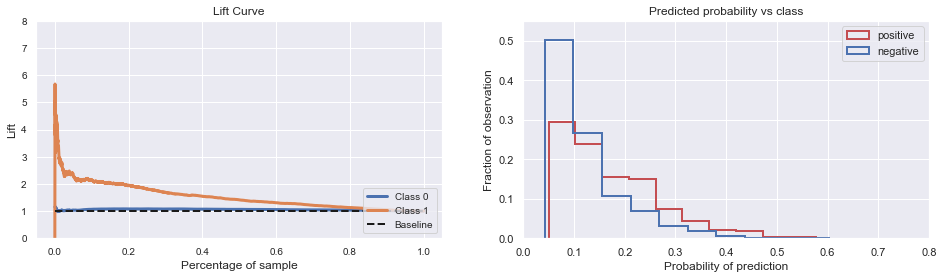

In [83]:
liftcurve_probahisto_score(trainmodel_cv, 
                           CatBoostClassifier(iterations=988, depth=2, learning_rate=0.07165), 
                           'CatB', 5, X_test, y_test, 8, 0.55, 0.8)

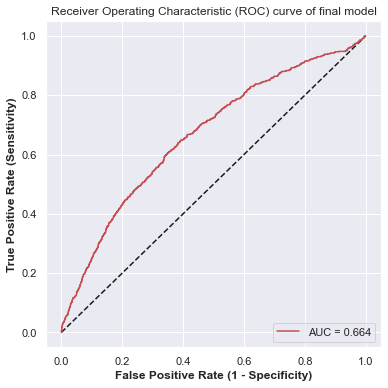

In [79]:
start_time = time.time()

final_model = trainmodel_cv(CatBoostClassifier(iterations=988, depth=2, learning_rate=0.07165, silent=True), 5)
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:,1]
#roc curve of lr model
lr_fpr,lr_tpr,threshold = roc_curve(y_test,y_pred_proba)
roc_auc_ = auc(lr_fpr,lr_tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(lr_fpr,lr_tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

In [80]:
# get feature importance for catboost on train dataset
from catboost import Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
feature_names = X.columns
#final_model = trainmodel_cv(CatBoostClassifier(iterations=939,  depth=4, learning_rate=0.014877, silent=True), 5)
feature_importances  = final_model.get_feature_importance(train_pool)

feature_df = pd.DataFrame(sorted(zip(feature_importances, feature_names), reverse=True), columns=['Feature Importance', 'Variable'])


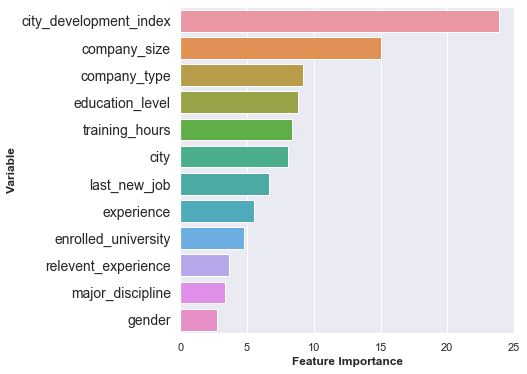

In [81]:
plt.figure(figsize=(6,6))
g = sns.barplot('Feature Importance', 'Variable', data=feature_df)
g.set_xlabel('Feature Importance',fontsize=12,weight='bold')
g.set_ylabel('Variable',size=12,weight='bold')
g.set_yticklabels(g.get_yticklabels(),size=14)
plt.show()

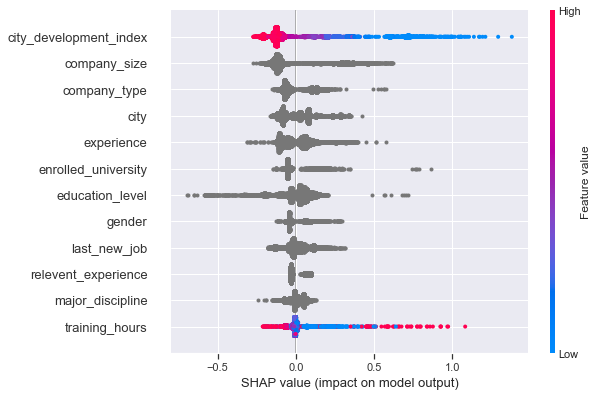

In [82]:
shap_values = final_model.get_feature_importance(Pool(X_train, label=y_train,cat_features=cat_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

# shap value for features
import shap
shap.initjs()

X_train_df = pd.DataFrame(X_train)
X_train_df.columns = X.columns


shap.summary_plot(shap_values, X_train_df)